# Confidence and Choice (One Layer) Visualizer

Run FF_estimation 10 times (cross-reference runDRAM_twolayer.sh in hydra), then copy all the checkpoints to guppy (cross-reference copyDRAM_classify_blobs_ckpts.sh in hydra and enter password 10x).

Make sure these are the <b>guppy</b> model_settings: <br />
min_edge = 2 <br />
max_edge = 5 <br />
min_blobs = 1 <br />
max_blobs = 15 (15 for training, 9 for testing)<br />
glimpses = max_blobs + 1 <br />
batch_size = 4500

You could then use this entire program or use ClassificationDistributions.ipynb to output confidence_one_run for each run, and set them as the confidence for each run in confidence_all_runs.

Make sure to change the `analysis_estimation_nds.py` file to have the correct neural network graph filename! Then, change the `model_name`, so that the correct model is restored and the data is saved in the correct directory. `iter_list` may need to be changed

In [1]:
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from analysis_estimation_nds import read_n, classify_imgs, classify_imgs_fh, classify_imgs_lh, classify_imgs_training
from analysis_estimation_nds import classify_imgs_CTA, classify_imgs_has_spacing, classify_imgs_one_fixed
from analysis_estimation_nds import classify_imgs_incr
import matplotlib.pyplot as plt
%matplotlib inline

9000
9000
hello sharon
hello sharon
hello sharon
hello sharon
hello sharon
hello sharon
hello sharon
hello sharon
hello sharon
hello sharon
hello sharon
['/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '-f', 'true', 'true', 'true', 'true', 'true', 'model_runs/-f/classify_log.csv', 'model_runs/-f/classifymodel_0.ckpt', 'model_runs/-f/classifymodel_', 'model_runs/-f/zzzdraw_data_5000.npy', 'false', 'true', 'false', 'false', 'true']
Instructions for updating:
keep_dims is deprecated, use keepdims instead
100
numerosity: 1
numerosity: 2
numerosity: 3
numerosity: 4
numerosity: 5
numerosity: 6
numerosity: 7
numerosity: 8
numerosity: 9
numerosity: 10
numerosity: 11
numerosity: 12
numerosity: 13
numerosity: 14
numerosity: 15
analysis_onelayer_nds.py


In [2]:
model_name = "New_DAA_decrs_fN"
num_runs = 10
iter_list = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
max_blobs = 15
min_blobs = 1

num_iters = len(iter_list)
output_size = max_blobs - min_blobs + 1 # 15
img_width = img_height = 100

data_directory = "data/" + model_name + "/"
m = 0.5

confidence_all_runs_fh = np.zeros([num_runs, num_iters, output_size, output_size]) 
choice_all_runs_fh = np.zeros([num_runs, num_iters, output_size, output_size]) 
confidence_all_runs_lh = np.zeros([num_runs, num_iters, output_size, output_size]) 
choice_all_runs_lh = np.zeros([num_runs, num_iters, output_size, output_size]) 
confidence_all_runs_training = np.zeros([num_runs, num_iters, output_size, output_size]) 
choice_all_runs_training = np.zeros([num_runs, num_iters, output_size, output_size]) 
confidence_all_runs_one_fixed = np.zeros([num_runs, num_iters, output_size, output_size]) 
choice_all_runs_one_fixed = np.zeros([num_runs, num_iters, output_size, output_size])

est_conf_all_runs_one_fixed = np.zeros([num_runs, num_iters, img_width, img_height]) 
est_choice_all_runs_one_fixed = np.zeros([num_runs, num_iters, img_width, img_height]) 


# See the effect of incrementing number of blobs 20191201
num_incr = 100
confidence_all_runs_N = np.zeros([num_runs, num_iters, output_size, output_size]) 
choice_all_runs_N = np.zeros([num_runs, num_iters, output_size, output_size])
confidence_all_runs_N_incr = np.zeros([num_runs, num_iters, output_size, num_incr, output_size]) 
choice_all_runs_N_incr = np.zeros([num_runs, num_iters, output_size, num_incr, output_size])

num_iters

import os
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

In [3]:
def fill_matrix_fh(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = 15000 # batch_size
    imgs_data = classify_imgs_fh(iteration, True, num_imgs, path=path) # new_imgs = True
        
    confidence_one_run = np.zeros([output_size, output_size])
    choice_one_run = np.zeros([output_size, output_size])

    for nb in range(output_size): 
        num_blobs = nb + min_blobs # 1 to 15
        confidence_hist = np.zeros(output_size)
        choice_hist = np.zeros(output_size)
        num_imgs_with_num_blobs = 0.00001

        for idx, data in enumerate(imgs_data):

            if data["label"][nb] == 1: # data is for an image with num_blobs blobs
                num_imgs_with_num_blobs += 1

                # Histogram of softmaxes
                confidence_hist += data["classifications"][0][0]

                # Histogram of choices
                choice = np.argmax(data["classifications"][0][0])
                choice_list = [0] * output_size
                choice_list[choice] = 1
                choice_hist += choice_list

        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run[nb] = confidence_hist.tolist()

        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run[nb] = choice_hist.tolist()
        
#     print("Confidence (One Run): ",confidence_one_run[nb])
#     print(confidence_one_run.tolist())
#     print("Choice (One Run): ",choice_one_run[nb])
#     print(choice_one_run.tolist())
    return confidence_one_run, choice_one_run

In [4]:
#for run in range(num_runs):
#    path = 'model_runs/' + model_name + '_run' + str(run + 1) # '/run_' if all the runs are stored in one folder
#    for i, iteration in enumerate(iter_list):
#        confidence_all_runs_fh[run, i], choice_all_runs_fh[run, i] = fill_matrix_fh(path, iteration)

In [5]:
def fill_matrix_lh(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = 15000 # batch_size
    imgs_data = classify_imgs_lh(iteration, True, num_imgs, path=path) # new_imgs = True
        
    confidence_one_run = np.zeros([output_size, output_size])
    choice_one_run = np.zeros([output_size, output_size])

    for nb in range(output_size): 
        num_blobs = nb + min_blobs # 1 to 15
        confidence_hist = np.zeros(output_size)
        choice_hist = np.zeros(output_size)
        num_imgs_with_num_blobs = 0.00001

        for idx, data in enumerate(imgs_data):

            if data["label"][nb] == 1: # data is for an image with num_blobs blobs
                num_imgs_with_num_blobs += 1

                # Histogram of softmaxes
                confidence_hist += data["classifications"][0][0]

                # Histogram of choices
                choice = np.argmax(data["classifications"][0][0])
                choice_list = [0] * output_size
                choice_list[choice] = 1
                choice_hist += choice_list

        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run[nb] = confidence_hist.tolist()

        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run[nb] = choice_hist.tolist()
        
#     print("Confidence (One Run): ",confidence_one_run[nb])
#     print(confidence_one_run.tolist())
#     print("Choice (One Run): ",choice_one_run[nb])
#     print(choice_one_run.tolist())
    return confidence_one_run, choice_one_run

In [6]:
#for run in range(num_runs):
#    path = 'model_runs/' + model_name + '_run' + str(run + 1) # '/run_' if all the runs are stored in one folder
#    for i, iteration in enumerate(iter_list):
#        confidence_all_runs_lh[run, i], choice_all_runs_lh[run, i] = fill_matrix_lh(path, iteration)

In [7]:
def fill_matrix_training(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = 15000 # batch_size
    imgs_data = classify_imgs_training(iteration, True, num_imgs, path=path) # new_imgs = True
        
    confidence_one_run = np.zeros([output_size, output_size])
    choice_one_run = np.zeros([output_size, output_size])

    for nb in range(output_size): 
        num_blobs = nb + min_blobs # 1 to 15
        confidence_hist = np.zeros(output_size)
        choice_hist = np.zeros(output_size)
        num_imgs_with_num_blobs = 0.00001

        for idx, data in enumerate(imgs_data):

            if data["label"][nb] == 1: # data is for an image with num_blobs blobs
                num_imgs_with_num_blobs += 1

                # Histogram of softmaxes
                confidence_hist += data["classifications"][0][0]

                # Histogram of choices
                choice = np.argmax(data["classifications"][0][0])
                choice_list = [0] * output_size
                choice_list[choice] = 1
                choice_hist += choice_list

        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run[nb] = confidence_hist.tolist()

        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run[nb] = choice_hist.tolist()
        
#     print("Confidence (One Run): ",confidence_one_run[nb])
#     print(confidence_one_run.tolist())
#     print("Choice (One Run): ",choice_one_run[nb])
#     print(choice_one_run.tolist())
    return confidence_one_run, choice_one_run

In [8]:
# for run in range(num_runs):
#     path = 'model_runs/' + model_name + '_run' + str(run + 1) # '/run_' if all the runs are stored in one folder
#     for i, iteration in enumerate(iter_list):        
#         confidence_all_runs_training[run, i], choice_all_runs_training[run, i] = fill_matrix_training(path, iteration)

In [9]:
def get_expected_classification(arr):
    running_total = 0
    for idx, val in enumerate(arr):
        numerosity = idx+1
        running_total = running_total + val*numerosity
    return running_total

In [10]:
def fill_matrix_one_fixed(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = 10000 # batch_size
    imgs_data = classify_imgs_one_fixed(iteration, True, num_imgs, path=path) # new_imgs = True
        
    confidence_one_run = np.zeros([output_size, output_size])
    choice_one_run = np.zeros([output_size, output_size])

    num_blobs = 2
    nb = num_blobs - 1
    confidence_hist = np.zeros(output_size)
    choice_hist = np.zeros(output_size)
    num_imgs_with_num_blobs = num_imgs
    
    est_conf_one_run = np.zeros([img_width, img_height]) #100x100 images
    est_choice_one_run = np.zeros([img_width, img_height]) #100x100 images

    for idx, data in enumerate(imgs_data):

        # Histogram of softmaxes
        confidence_hist += data["classifications"][0][0]

        # Histogram of choices
        choice = np.argmax(data["classifications"][0][0])
        choice_list = [0] * output_size
        choice_list[choice] = 1
        choice_hist += choice_list
                
        # Classifications for different blob positions, graph the center coordinate of blob
        blob_x, blob_y = data["blob_coords"][idx][0], data["blob_coords"][idx][1]
        est_conf_one_run[int(blob_x)+1][int(blob_y)+1] = get_expected_classification(data["classifications"][0][0])
#         print("conf: %f" % get_expected_classification(data["classifications"][0][0]))
        est_choice_one_run[int(blob_x)+1][int(blob_y)+1] = np.argmax(data["classifications"][0][0])+1
#         print("choice: %d" % np.argmax(data["classifications"][0][0]))

    confidence_hist = confidence_hist / num_imgs_with_num_blobs
    confidence_one_run[nb] = confidence_hist.tolist()

    choice_hist = choice_hist / num_imgs_with_num_blobs
    choice_one_run[nb] = choice_hist.tolist()
        
#     print("Confidence (One Run): ",confidence_one_run[nb])
#     print(confidence_one_run.tolist())
#     print("Choice (One Run): ",choice_one_run[nb])
#     print(choice_one_run.tolist())
    return confidence_one_run, choice_one_run, est_conf_one_run, est_choice_one_run

In [11]:
import random
random.randint(1, 99-3)

78

In [12]:
# for run in range(num_runs):
#     path = 'model_runs/' + model_name + '_run' + str(run + 1) # '/run_' if all the runs are stored in one folder
#     for i, iteration in enumerate(iter_list):
#         confidence_all_runs_one_fixed[run, i], choice_all_runs_one_fixed[run, i], est_conf_all_runs_one_fixed[run, i], est_choice_all_runs_one_fixed[run, i] = fill_matrix_one_fixed(path, iteration)

In [13]:
def fill_matrix_incr(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = 100
    num_incr = 100
    imgs_data_all_N = classify_imgs_incr(iteration, False, path=path) # new_imgs = False
    
    confidence_one_run_N = np.zeros([output_size, output_size])
    choice_one_run_N = np.zeros([output_size, output_size])
    confidence_one_run_N_incr = np.zeros([output_size, num_incr, output_size])
    choice_one_run_N_incr = np.zeros([output_size, num_incr, output_size])
    
    num_imgs_with_num_blobs = num_imgs

    for n, imgs_data in enumerate(imgs_data_all_N):
        
        confidence_hist = np.zeros(output_size)
        choice_hist = np.zeros(output_size)
        
        for idx, data in enumerate(imgs_data):
            # Histogram of softmaxes
            confidence_hist += data["classifications"][0]

            # Histogram of choices
            choice = np.argmax(data["classifications"][0])
            choice_list = [0] * output_size
            choice_list[choice] = 1
            choice_hist += choice_list
            
            # Get all the data from the images with N+1 blobs
            confidence_hist_for_img_incr = np.zeros(output_size)
            confidence_hist_for_img = np.zeros(output_size)
            choice_hist_for_img = np.zeros(output_size)
            for cs_idx, cs in enumerate(data["classifications_incr"]):
                # Histogram of softmaxes
                confidence_hist_for_img += data["classifications"][0]
                # Histogram of choices
                choice_for_img = np.argmax(data["classifications"][0])
                choice_list_for_img = [0] * output_size
                choice_list_for_img[choice_for_img] = 1
                choice_hist_for_img += choice_list
                
            confidence_hist_for_img = confidence_hist / num_imgs_with_num_blobs
            confidence_one_run_N_incr[n][idx] = confidence_hist_for_img.tolist()

            choice_hist_for_img = choice_hist / num_imgs_with_num_blobs
            choice_one_run_N_incr[n][idx] = choice_hist_for_img.tolist()
                 
                

        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run_N[n] = confidence_hist.tolist()

        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run_N[n] = choice_hist.tolist()
        
#     print("Confidence (One Run): ",confidence_one_run[nb])
#     print(confidence_one_run.tolist())
#     print("Choice (One Run): ",choice_one_run[nb])
#     print(choice_one_run.tolist())

    return confidence_one_run_N, choice_one_run_N, confidence_one_run_N_incr, choice_one_run_N_incr

In [14]:
for run in range(num_runs):
    path = 'model_runs/' + model_name + '_run' + str(run + 1) # '/run_' if all the runs are stored in one folder
    for i, iteration in enumerate(iter_list):
        # See the effect of incrementing number of blobs 20191201
        confidence_all_runs_N[run, i], choice_all_runs_N[run, i], confidence_all_runs_N_incr[run, i], choice_all_runs_N_incr[run, i] = fill_matrix_incr(path, iteration)

INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_1600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_6400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run1/classifymodel_819200.ckpt
INFO:t

INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run6/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run6/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run6/classifymodel_819200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run6/classifymodel_1000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run6/classifymodel_1228800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run6/classifymodel_1638400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run6/classifymodel_2000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run6/classifymodel_3000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run7/classifymodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_run7/classifymodel_20

In [15]:
choice_all_runs_N[9][9] # 10x15x9x9

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.94, 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.03, 0.45, 0.52, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.65, 0.25, 0.09, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.04, 0.33, 0.31, 0.19, 0.13, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.14, 0.26, 0.46, 0.09, 0.  ,
        0.01, 0.01, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.1 , 0.46, 0.17, 0.06,
        0.08, 0.  , 0.06, 0.05],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.21, 0.17, 0.07,
        0.22, 0.03, 0.23, 0.06],
       [0.  , 0.  , 0.  , 0.  , 0.  ,

In [16]:
def adj_all_runs(all_runs_matrix):
    """Adjust all the matrices so tick marks start with 1."""
    
    new_all_runs_matrix = np.zeros([num_runs, num_iters, output_size + 1, output_size + 1])
    for m, matrix in enumerate(all_runs_matrix):
        for i in range(num_iters):
            new_all_runs_matrix[m, i] = adj_matrix(matrix[i])
    return new_all_runs_matrix


def adj_matrix(matrix):
    """Adjust the matrix so tick marks start with 1."""
    
    a = np.zeros([1, output_size])
    temp = np.vstack((a, matrix))
    b = np.zeros([output_size + 1, 1])
    new_matrix = np.hstack((b, temp))
    return new_matrix

#confidence_all_runs_adj_fh = adj_all_runs(confidence_all_runs_fh)
#choice_all_runs_adj_fh = adj_all_runs(choice_all_runs_fh)
#confidence_all_runs_adj_lh = adj_all_runs(confidence_all_runs_lh)
#choice_all_runs_adj_lh = adj_all_runs(choice_all_runs_lh)

In [17]:
#confidence_all_runs_adj_training = adj_all_runs(confidence_all_runs_training)
#choice_all_runs_adj_training = adj_all_runs(choice_all_runs_training)
# confidence_all_runs_adj_one_fixed = adj_all_runs(confidence_all_runs_one_fixed)
# choice_all_runs_adj_one_fixed = adj_all_runs(confidence_all_runs_N)
confidence_all_runs_adj_N = adj_all_runs(confidence_all_runs_N)
choice_all_runs_adj_N = adj_all_runs(choice_all_runs_N)    

In [18]:
#confidence_avg_fh = np.mean(confidence_all_runs_adj_fh, axis=0)
#choice_avg_fh = np.mean(choice_all_runs_adj_fh, axis=0)
#confidence_avg_lh = np.mean(confidence_all_runs_adj_lh, axis=0)
#choice_avg_lh = np.mean(choice_all_runs_adj_lh, axis=0)

In [19]:
#confidence_avg_training = np.mean(confidence_all_runs_adj_training, axis=0)
#choice_avg_training = np.mean(choice_all_runs_adj_training, axis=0)
# confidence_avg_one_fixed = np.mean(confidence_all_runs_adj_one_fixed, axis=0)
# choice_avg_one_fixed = np.mean(choice_all_runs_adj_one_fixed, axis=0)
confidence_avg_N = np.mean(confidence_all_runs_adj_N, axis=0)
choice_avg_N = np.mean(choice_all_runs_adj_N, axis=0)

In [20]:
def plot_confidence_fh(iter_idx, it, run=None):
    """Plot the confidence heatmap."""
    
    if run is None:
        matrix = confidence_avg_fh[iter_idx]
        plot_title = "F500: Confidence after %d Iterations" % (it)

    else:
        matrix = confidence_all_runs_adj_fh[run, iter_idx]
        plot_title = "F500: Confidence at Run %d after %d Iterations" % (run + 1, it)
    plot_heatmap(matrix, plot_title)


def plot_choice_fh(iter_idx, it, run=None):
    """Plot the choice heatmap."""
    
    if run is None:
        matrix = choice_avg_fh[iter_idx]
        plot_title = "F500: Choice after %d Iterations" % (it)
    else:
        matrix = choice_all_runs_adj_fh[run, iter_idx]
        plot_title = "F500: Choice at Run %d after %d Iterations" % (run + 1, it)
    plot_heatmap(matrix, plot_title)

def plot_confidence_lh(iter_idx, it, run=None):
    """Plot the confidence heatmap."""
    
    if run is None:
        matrix = confidence_avg_lh[iter_idx]
        plot_title = "L500: Confidence after %d Iterations" % (it)

    else:
        matrix = confidence_all_runs_adj_lh[run, iter_idx]
        plot_title = "L500: Confidence at Run %d after %d Iterations" % (run + 1, it)
    plot_heatmap(matrix, plot_title)


def plot_choice_lh(iter_idx, it, run=None):
    """Plot the choice heatmap."""
    
    if run is None:
        matrix = choice_avg_lh[iter_idx]
        plot_title = "L500: Choice after %d Iterations" % (it)
    else:
        matrix = choice_all_runs_adj_lh[run, iter_idx]
        plot_title = "L500: Choice at Run %d after %d Iterations" % (run + 1, it)
    plot_heatmap(matrix, plot_title)

def plot_heatmap(matrix, plot_title):
    """Plot heatmap."""
    
    data = [go.Heatmap(
        z=matrix,
        colorscale="Jet"
    )]

    layout = go.Layout(
        title=plot_title,
        yaxis=dict(
#             range=[max_blobs + m, min_blobs - m],
            range=[9 + m, min_blobs - m],
            title="True Class",
            dtick=1,
            tickcolor='#FFF'
        ),
        xaxis=dict(
            range=[min_blobs - m, max_blobs + m],
            title="Predicted Class",
            dtick=1,
            tickcolor='#FFF'
        ),
        width=500,
        height=500,
        plot_bgcolor="#000",
        paper_bgcolor="#000",
        font=dict(
            color="#FFF"
        ),
        titlefont=dict(
            color="#FFF"
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [21]:
# for i, it in enumerate(iter_list):
    #plot_confidence_lh(i, it)
    #plot_confidence_lh(i, it)
    #plot_choice_fh(i, it)
    #plot_choice_lh(i, it)

In [22]:
#for i, it in enumerate(iter_list):
    #plot_confidence(i, it)
    #plot_choice_lh(i, it)

In [23]:
#np.save(data_directory + "confidence_hist_fh", confidence_all_runs_fh)
#np.save(data_directory + "choice_hist_fh", choice_all_runs_fh)
#np.save(data_directory + "confidence_hist_lh", confidence_all_runs_lh)
#np.save(data_directory + "choice_hist_lh", choice_all_runs_lh)

In [24]:
#np.save(data_directory + "confidence_hist_training", confidence_all_runs_training)
#np.save(data_directory + "choice_hist_training", choice_all_runs_training)
# np.save(data_directory + "confidence_hist_one_fixed_span", confidence_all_runs_one_fixed)
# np.save(data_directory + "choice_hist_one_fixed_span", choice_all_runs_one_fixed)
np.save(data_directory + "confidence_hist_N", confidence_all_runs_N)
np.save(data_directory + "choice_hist_N", choice_all_runs_N)
np.save(data_directory + "confidence_hist_N_incr", confidence_all_runs_N_incr)
np.save(data_directory + "choice_hist_N_incr", choice_all_runs_N_incr)

In [25]:
#confidence_hist_fh = np.load(data_directory + "confidence_hist_fh.npy")
#choice_hist_fh = np.load(data_directory + "choice_hist_fh.npy")
#confidence_hist_lh = np.load(data_directory + "confidence_hist_lh.npy")
#choice_hist_lh = np.load(data_directory + "choice_hist_lh.npy")

In [26]:
#confidence_hist_training = np.load(data_directory + "confidence_hist_training.npy")
#choice_hist_training = np.load(data_directory + "choice_hist_training.npy")
# confidence_hist_one_fixed = np.load(data_directory + "confidence_hist_one_fixed_span.npy")
# choice_hist_one_fixed = np.load(data_directory + "choice_hist_one_fixed_span.npy")
confidence_hist_N = np.load(data_directory + "confidence_hist_N.npy")
choice_hist_N = np.load(data_directory + "choice_hist_N.npy")

In [27]:
def get_msdcv(hist_matrix):
    """Get the mean, standard deviation, and coefficient of variation matrices from histogram matrix."""
    
    msdcv = np.zeros([num_runs, num_iters, output_size, 3])
    
    for run in range(num_runs):
        for i, it in enumerate(iter_list):
            for t in range(output_size):
                values_sum = 0
                sqr_sum = 0

                # Find the mean
                for p in range(output_size):
                    values_sum += (p + 1) * hist_matrix[run, i, t, p]
                msdcv[run, i, t, 0] = mu = values_sum

                # Find the standard deviation
                for p in range(output_size):
                    sqr_sum += (p + 1 - mu)**2 * hist_matrix[run, i, t, p]
                msdcv[run, i, t, 1] = sigma = np.sqrt(sqr_sum)

                # Find the coefficient of variation
                msdcv[run, i, t, 2] = cv = sigma / mu
    return msdcv

In [28]:
#confidence_msdcv_fh = get_msdcv(confidence_hist_fh)
#choice_msdcv_fh = get_msdcv(choice_hist_fh)
#confidence_msdcv_lh = get_msdcv(confidence_hist_lh)
#choice_msdcv_lh = get_msdcv(choice_hist_lh)

In [29]:
#confidence_msdcv_training = get_msdcv(confidence_hist_training)
#choice_msdcv_training = get_msdcv(choice_hist_training)
# confidence_msdcv_one_fixed = get_msdcv(confidence_hist_one_fixed)
# choice_msdcv_one_fixed = get_msdcv(choice_hist_one_fixed)
confidence_msdcv_N = get_msdcv(confidence_hist_N)
choice_msdcv_N = get_msdcv(choice_hist_N)

In [30]:
#np.save(data_directory + "confidence_msdcv_fh", confidence_msdcv_fh)
#np.save(data_directory + "choice_msdcv_fh", choice_msdcv_fh)
#np.save(data_directory + "confidence_msdcv_lh", confidence_msdcv_lh)
#np.save(data_directory + "choice_msdcv_lh", choice_msdcv_lh)

In [31]:
#np.save(data_directory + "confidence_msdcv_training", confidence_msdcv_training)
#np.save(data_directory + "choice_msdcv_training", choice_msdcv_training)
np.save(data_directory + "confidence_msdcv_N", confidence_msdcv_N)
np.save(data_directory + "choice_msdcv_N", choice_msdcv_N)

# One Fixed Blob Data

In [32]:
# est_conf_avg_one_fixed = np.mean(est_conf_all_runs_one_fixed, axis=0)
# est_choice_avg_one_fixed = np.mean(est_choice_all_runs_one_fixed, axis=0)
# np.save(data_directory + "est_conf_avg_one_fixed_span", est_conf_avg_one_fixed)
# np.save(data_directory + "est_choice_avg_one_fixed_span", est_choice_avg_one_fixed)

## Visualize Mean, Standard Deviation, and Coefficient of Variation

In [33]:
# chist = np.load(data_directory + "confidence_hist.npy")
# cm = np.load(data_directory + "confidence_msdv.npy")
chist = np.load(data_directory + "choice_hist_N.npy") # chist[run, i, output_size, output_size]
cm = np.load(data_directory + "choice_msdcv_N.npy") # cm[run, i ,t ,3]
cmus = cm[:,:,0:9,0] # mean
csds = cm[:,:,0:9,1] # sd
ccvs = cm[:,:,0:9,2] # cv

In [34]:
chist_mu = np.mean(chist,axis=0)
chist_min = np.min(chist,axis=0)
chist_max = np.max(chist,axis=0)
cmus_mu = np.mean(cmus,axis=0)
cmus_min = np.min(cmus,axis=0)
cmus_max = np.max(cmus,axis=0)
csds_mu = np.mean(csds,axis=0)
csds_min = np.min(csds,axis=0)
csds_max = np.max(csds,axis=0)
ccvs_mu = np.mean(ccvs,axis=0)
ccvs_min = np.min(ccvs,axis=0)
ccvs_max = np.max(ccvs,axis=0)

In [35]:
# baseline
x = [1,2,3,4,5,6,7,8,9]
rf = np.divide(1,np.square(x)) # 1/(x^2)
d = np.sum(rf)
f = np.divide(rf,d)

In [36]:
def plot_hists(i_ind):
    mumat = chist_mu[i_ind,:,0:9]
    minmat = chist_min[i_ind,:,0:9]
    maxmat = chist_max[i_ind,:,0:9]
    fig, ax = plt.subplots(9,1,sharex=True, sharey=True,figsize=(5,10))
    x = [1,2,3,4,5,6,7,8,9]
    fig.tight_layout()
    plt.xticks([1,2,3,4,5,6,7,8,9])
    tstr = 'I = ' + str(iter_list[i_ind])
    ax[0].set_title(tstr)
    for i in range(9):
        ax[i].plot(x,mumat[i,:],'k-')
        ax[i].fill_between(x,minmat[i,:],maxmat[i,:], facecolor='orange')
        ax[i].plot(x,f)
    plt.show()

In [37]:
def plot_one_hist(run,i_ind):
    mumat = chist[run-1,i_ind,:,0:9]
    fig, ax = plt.subplots(9,1,sharex=True, sharey=True,figsize=(5,10))
    x = [1,2,3,4,5,6,7,8,9]
    fig.tight_layout()
    plt.xticks([1,2,3,4,5,6,7,8,9])
    tstr = 'Run = ' + str(run) + ', Iter = ' + str(iter_list[i_ind])
    ax[0].set_title(tstr)
    for i in range(9):
        ax[i].plot(x,mumat[i,:],'k-')
    plt.show()

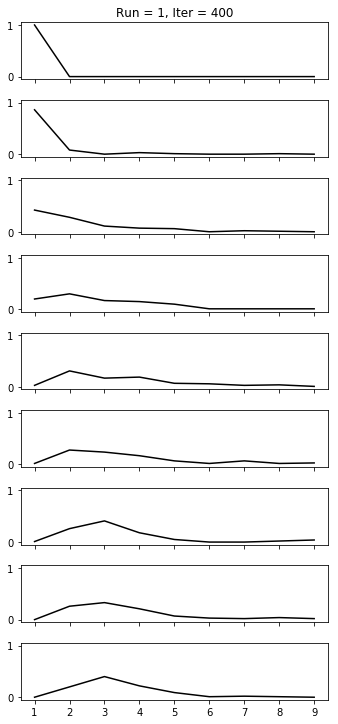

In [38]:
plot_one_hist(1,2) # Run =1, Iter = 1000

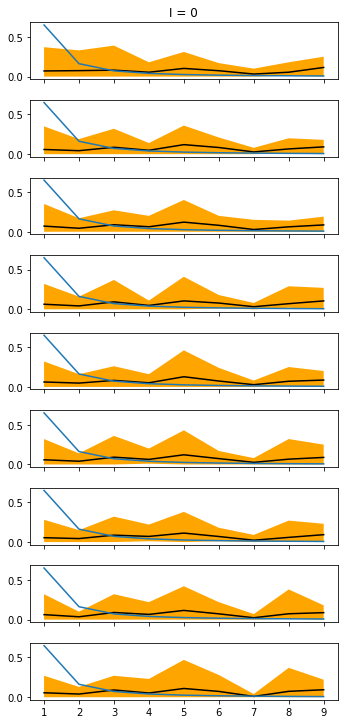

In [39]:
plot_hists(0) # All runs

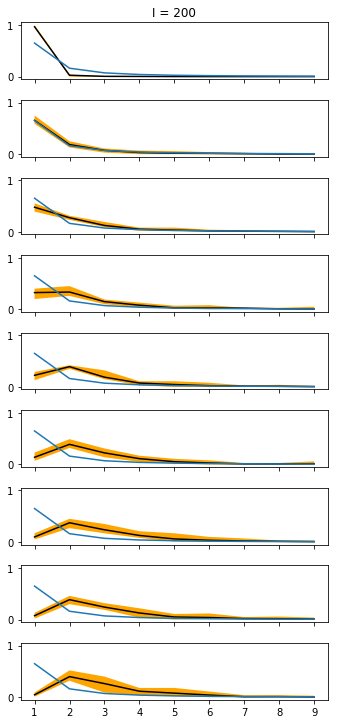

In [40]:
plot_hists(1)

In [41]:
plot_hists(50)

IndexError: index 50 is out of bounds for axis 0 with size 15

In [ ]:
plot_hists(110)

In [ ]:
def plot_stats(smu,smin,smax):
    fig, ax = plt.subplots(num_iters, sharex=True, sharey=True,figsize=(5,70))
    fig.tight_layout()
    plt.xticks([1,2,3,4,5,6,7,8,9])
    x = [1,2,3,4,5,6,7,8,9]
    for i in range(num_iters):
        tstr = 'I = ' + str(iter_list[i])
        ax[i].set_title(tstr)
        ax[i].plot(x,smu[i,:],'k-')
        ax[i].fill_between(x,smin[i,:],smax[i,:], facecolor='orange')
    plt.show()

In [ ]:
plot_stats(cmus_mu,cmus_min,cmus_max) # mean

In [ ]:
plot_stats(csds_mu,csds_min,csds_max) # standard deviation

In [ ]:
plot_stats(ccvs_mu,ccvs_min,ccvs_max) # cv

In [ ]:
# choice_avg: [num_iters, output_size, output_size]
choice_hist = np.zeros([num_iters,10])
for i in range (num_iters):
    for j in range(10):
        choice_hist[i,j] = choice_avg[i,j,j]

In [ ]:
def plot_choice_hists():
    fig, ax = plt.subplots(9,1,sharex=True, sharey=True,figsize=(5,10))
    x = [1,2,3,4,5,6,7,8,9]
    fig.tight_layout()
    plt.xticks([1,2,3,4,5,6,7,8,9])
    #tstr = 'I = ' + str(iter_list[i_ind])
    #ax[0].set_title(tstr)
    for i in range(num_iters):
        for j in range(10):
            ax[j].plot(x,choice_hist[i,j],'k-')
    plt.show()

In [ ]:
import numpy as np

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

x = np.linspace(iter_list[0], iter_list[num_iters-1], num_iters)
y = choice_hist[:,5]

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

p = figure(title="Another Legend Example", tools=TOOLS)

p.line(x, choice_hist[:,1], legend="1",line_color="red", line_width=3)
p.line(x, choice_hist[:,2], legend="2", line_color="orange", line_width=3)
p.line(x, choice_hist[:,3], legend="3", line_color="yellow", line_width=3)
p.line(x, choice_hist[:,4], legend="4", line_color="green", line_width=3)
p.line(x, choice_hist[:,5], legend="5", line_color="blue")
p.line(x, choice_hist[:,6], legend="6", line_color="purple", line_width=3)
p.line(x, choice_hist[:,7], legend="7", line_color="olivedrab", line_width=3)
p.line(x, choice_hist[:,8], legend="8", line_color="tomato", line_width=3)
p.line(x, choice_hist[:,9], legend="9", line_color="gold", line_width=3)
p.xaxis.axis_label = "Iterations"
p.yaxis.axis_label = "Ave"
show(gridplot(p, ncols=2, plot_width=800, plot_height=800,title="legend.py example"))  # open a browser